In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/沥青月差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['沥青月差（主力-次主力）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,沥青月差（主力-次主力）,石油沥青：国内企业：库存：中国（周）同差,山东汽柴油加权裂解价差,沥青周度产量超季节性/3年,WTI连1-连4月差,沥青仓单（仓库+厂库）同差,华东沥青基差,沥青厂库大样本拼接小样本4周环差,BU-SC（期货指数）5年百分位超季节性/5年
2025-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/WTI连1-连4月差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/WTI连1-连4月差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/WTI连1-连4月差_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()   

,Date,预测值
20,2025-11-03,0.790000
19,2025-11-04,1.665168
18,2025-11-05,1.711848
17,2025-11-06,1.417764
16,2025-11-07,1.459776


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/山东柴油裂解差(多因子)_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/山东柴油裂解差(多因子)_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/山东柴油裂解差(多因子)_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['真实值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")
sheet2.head()  

,Date,预测值
19,2025-11-03,269.0
18,2025-11-04,263.3
17,2025-11-05,280.7
16,2025-11-06,309.3
15,2025-11-07,298.7


In [7]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/汽油裂解差(多因子)_合并数据.xlsx"),    
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/汽油裂解差(多因子)_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/汽油裂解差(多因子)_合并数据.xlsx")
]

file_path3 = None
for path in file_paths3:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path3 = path   
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.read_excel(file_path3, sheet_name='Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['真实值'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
    sheet3.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,预测值
19,2025-10-31,385.4
18,2025-11-03,443.1
17,2025-11-04,644.0
16,2025-11-05,599.8
15,2025-11-06,482.7


In [8]:
sheet4 = pd.DataFrame()
sheet4['Date'] = sheet3['Date']
sheet4['山东汽柴油加权裂解价'] = (sheet3['预测值'] + 2*sheet2['预测值']) / 3
sheet4.head()

,Date,山东汽柴油加权裂解价
19,2025-10-31,307.800000
18,2025-11-03,323.233333
17,2025-11-04,401.800000
16,2025-11-05,406.133333
15,2025-11-06,360.033333


In [9]:
sheet.columns

Index(['沥青月差（主力-次主力）', '石油沥青：国内企业：库存：中国（周）同差', '山东汽柴油加权裂解价差', '沥青周度产量超季节性/3年',
       'WTI连1-连4月差', '沥青仓单（仓库+厂库）同差', '华东沥青基差', '沥青厂库大样本拼接小样本4周环差',
       'BU-SC（期货指数）5年百分位超季节性/5年'],
      dtype='object')

In [10]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['WTI连1-连4月差'] = sheet_daily['WTI连1-连4月差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# sheet 4
sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', '山东汽柴油加权裂解价']],
    on='Date',
    how='left'
)
sheet_daily['山东汽柴油加权裂解价差'] = sheet_daily['山东汽柴油加权裂解价差'].fillna(sheet_daily['山东汽柴油加权裂解价'])
sheet_daily = sheet_daily.drop(columns=['山东汽柴油加权裂解价'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [11]:

# 找出LME铜价、人民币汇率收盘价、秦皇岛动力煤价格都有值的最后一天
last_valid_day = sheet[['山东汽柴油加权裂解价差', 'WTI连1-连4月差']].dropna().index[-1]

# 截取到该日期
sheet = sheet.loc[:last_valid_day]
sheet.tail(10)

,沥青月差（主力-次主力）,石油沥青：国内企业：库存：中国（周）同差,山东汽柴油加权裂解价差,沥青周度产量超季节性/3年,WTI连1-连4月差,沥青仓单（仓库+厂库）同差,华东沥青基差,沥青厂库大样本拼接小样本4周环差,BU-SC（期货指数）5年百分位超季节性/5年
Date,,,,,,,,,
2025-11-14,NaN,NaN,406.100000,NaN,1.254384,NaN,NaN,NaN,NaN
2025-11-17,NaN,NaN,397.600000,NaN,1.233378,NaN,NaN,NaN,NaN
2025-11-18,NaN,NaN,388.266667,NaN,1.487784,NaN,NaN,NaN,NaN
2025-11-19,NaN,NaN,436.500000,NaN,1.982592,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,419.900000,NaN,1.885731,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,418.200000,NaN,1.790037,NaN,NaN,NaN,NaN
2025-11-24,NaN,NaN,427.733333,NaN,1.613820,NaN,NaN,NaN,NaN
2025-11-25,NaN,NaN,435.133333,NaN,1.917240,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,427.900000,NaN,1.952250,NaN,NaN,NaN,NaN


In [12]:
sheet.columns

Index(['沥青月差（主力-次主力）', '石油沥青：国内企业：库存：中国（周）同差', '山东汽柴油加权裂解价差', '沥青周度产量超季节性/3年',
       'WTI连1-连4月差', '沥青仓单（仓库+厂库）同差', '华东沥青基差', '沥青厂库大样本拼接小样本4周环差',
       'BU-SC（期货指数）5年百分位超季节性/5年'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
    '石油沥青：国内企业：库存：中国（周）同差':'interpolate',
    '山东汽柴油加权裂解价差':'interpolate',  
    '沥青周度产量超季节性/3年':'interpolate',
    'WTI连1-连4月差':'interpolate', 
    '沥青仓单（仓库+厂库）同差':'interpolate', 
    '华东沥青基差':'interpolate',
    '沥青厂库大样本拼接小样本4周环差':'interpolate',
    'BU-SC（期货指数）5年百分位超季节性/5年':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['石油沥青：国内企业：库存：中国（周）同差_提前20天'] = sheet['石油沥青：国内企业：库存：中国（周）同差'].shift(20)
sheet['沥青周度产量超季节性/3年_提前20天'] = sheet['沥青周度产量超季节性/3年'].shift(20)
sheet['沥青仓单（仓库+厂库）同差_提前20天'] = sheet['沥青仓单（仓库+厂库）同差'].shift(20)
sheet['华东沥青基差_提前20天'] = sheet['华东沥青基差'].shift(20)
sheet['沥青厂库大样本拼接小样本4周环差_提前30天'] = sheet['沥青厂库大样本拼接小样本4周环差'].shift(30)
sheet['BU-SC（期货指数）5年百分位超季节性/5年_提前20天'] = sheet['BU-SC（期货指数）5年百分位超季节性/5年'].shift(20)

sheet['山东汽柴油加权裂解价差_逆序'] = reverse_column(sheet, '山东汽柴油加权裂解价差')
sheet['沥青周度产量超季节性/3年_提前20天_逆序'] = reverse_column(sheet, '沥青周度产量超季节性/3年_提前20天')
sheet['石油沥青：国内企业：库存：中国（周）同差_提前20天_逆序'] = reverse_column(sheet, '石油沥青：国内企业：库存：中国（周）同差_提前20天')
sheet['沥青仓单（仓库+厂库）同差_提前20天_逆序'] = reverse_column(sheet, '沥青仓单（仓库+厂库）同差_提前20天')
sheet['沥青厂库大样本拼接小样本4周环差_提前30天_逆序'] = reverse_column(sheet, '沥青厂库大样本拼接小样本4周环差_提前30天')
sheet['BU-SC（期货指数）5年百分位超季节性/5年_提前20天_逆序'] = reverse_column(sheet, 'BU-SC（期货指数）5年百分位超季节性/5年_提前20天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2020-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['沥青月差（主力-次主力）'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [14]:
sheet_daily.columns

Index(['Date', '沥青月差（主力-次主力）', '石油沥青：国内企业：库存：中国（周）同差', '山东汽柴油加权裂解价差',
       '沥青周度产量超季节性/3年', 'WTI连1-连4月差', '沥青仓单（仓库+厂库）同差', '华东沥青基差',
       '沥青厂库大样本拼接小样本4周环差', 'BU-SC（期货指数）5年百分位超季节性/5年',
       '石油沥青：国内企业：库存：中国（周）同差_提前20天', '沥青周度产量超季节性/3年_提前20天',
       '沥青仓单（仓库+厂库）同差_提前20天', '华东沥青基差_提前20天', '沥青厂库大样本拼接小样本4周环差_提前30天',
       'BU-SC（期货指数）5年百分位超季节性/5年_提前20天', '山东汽柴油加权裂解价差_逆序',
       '沥青周度产量超季节性/3年_提前20天_逆序', '石油沥青：国内企业：库存：中国（周）同差_提前20天_逆序',
       '沥青仓单（仓库+厂库）同差_提前20天_逆序', '沥青厂库大样本拼接小样本4周环差_提前30天_逆序',
       'BU-SC（期货指数）5年百分位超季节性/5年_提前20天_逆序'],
      dtype='object')

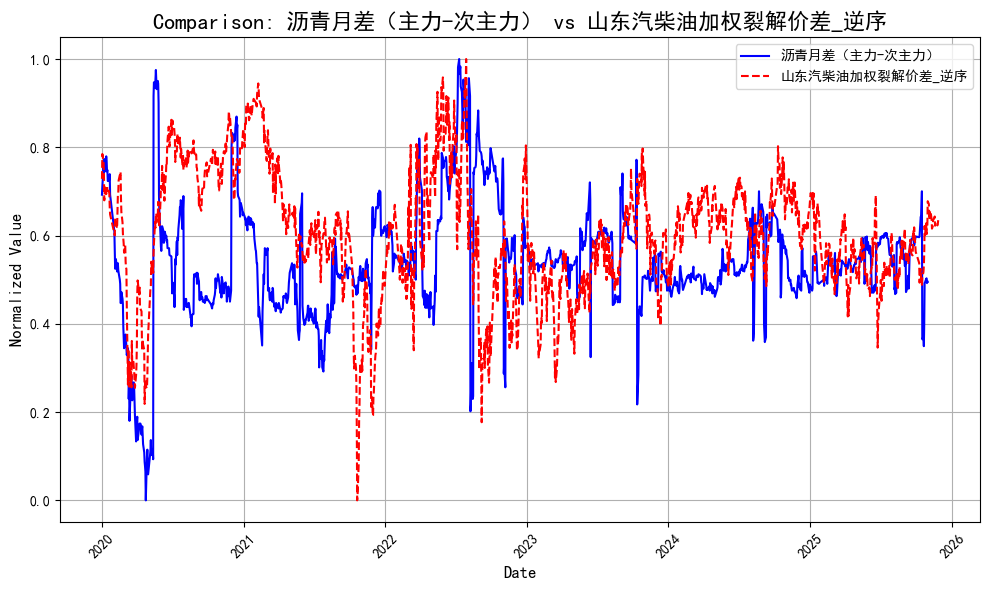

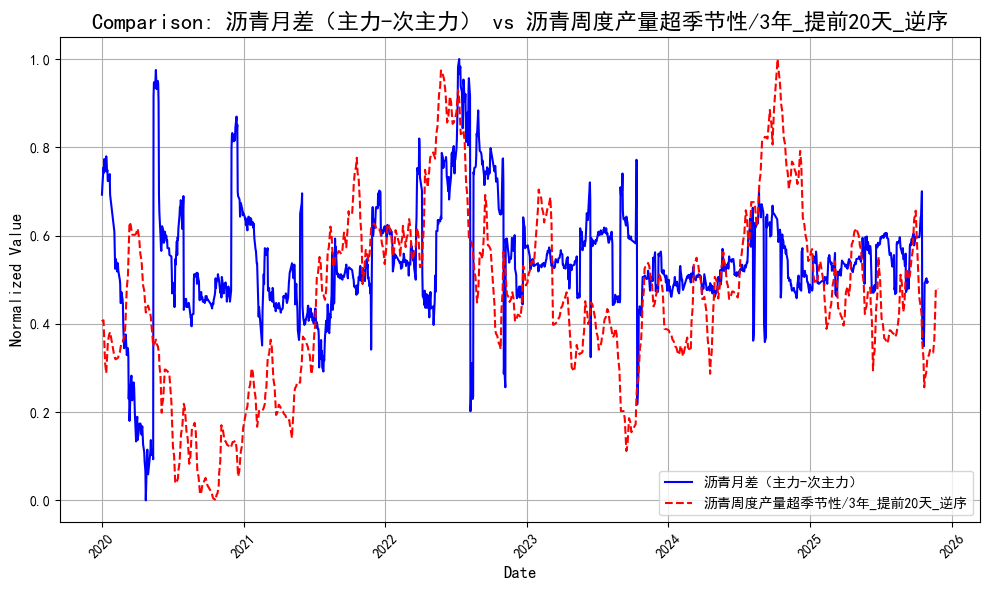

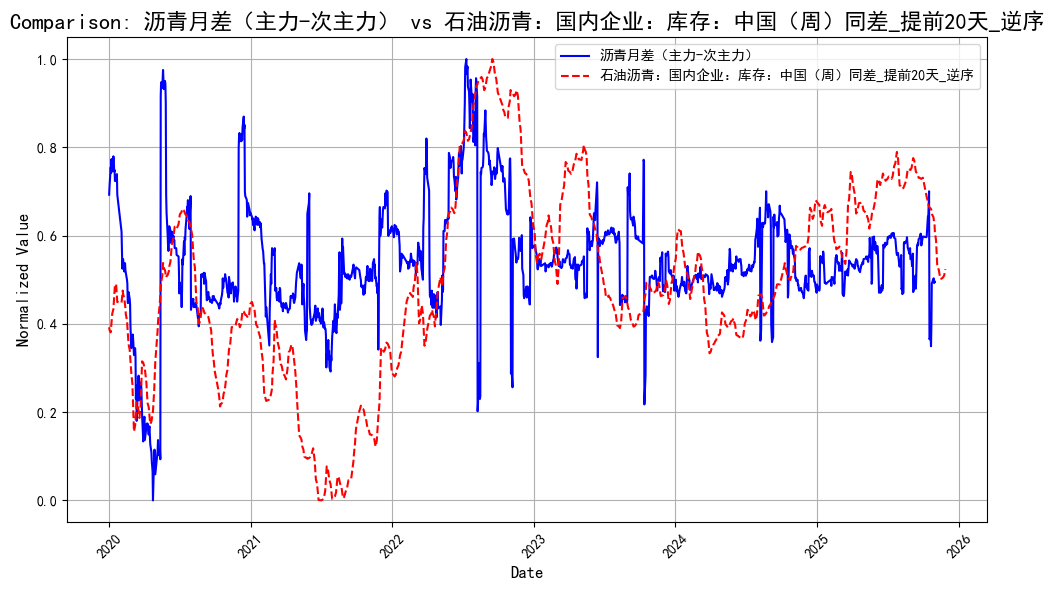

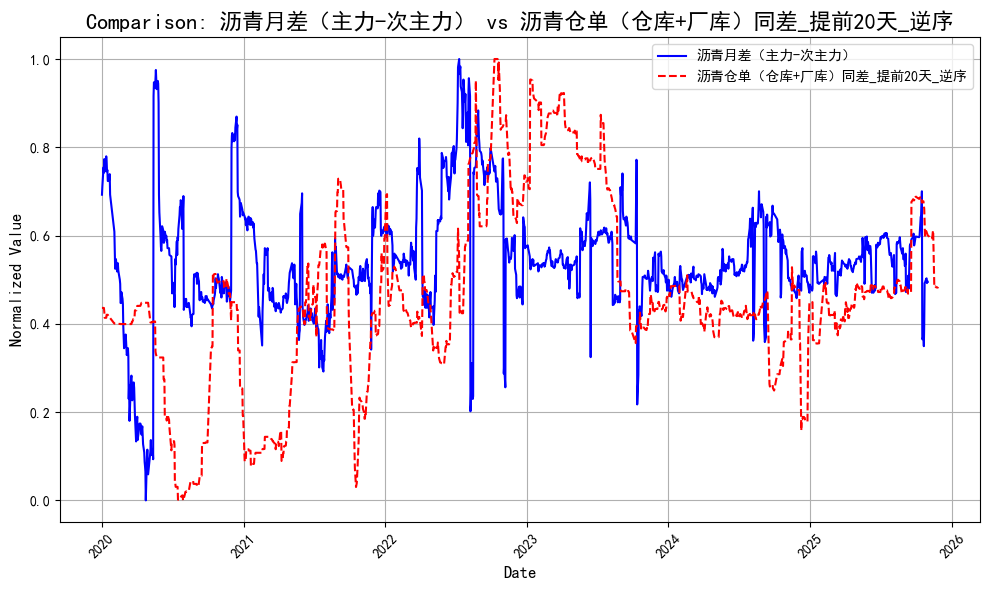

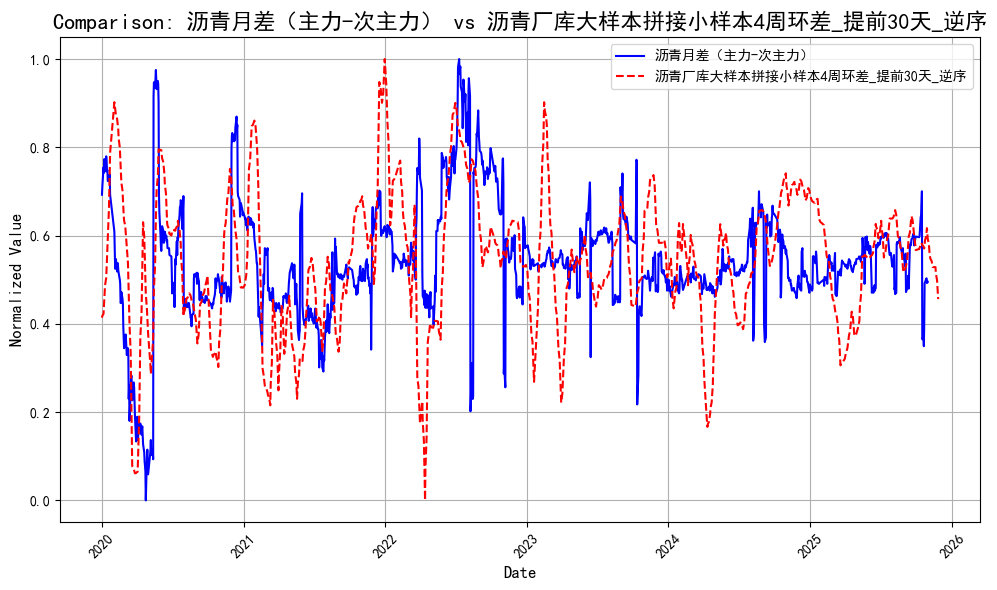

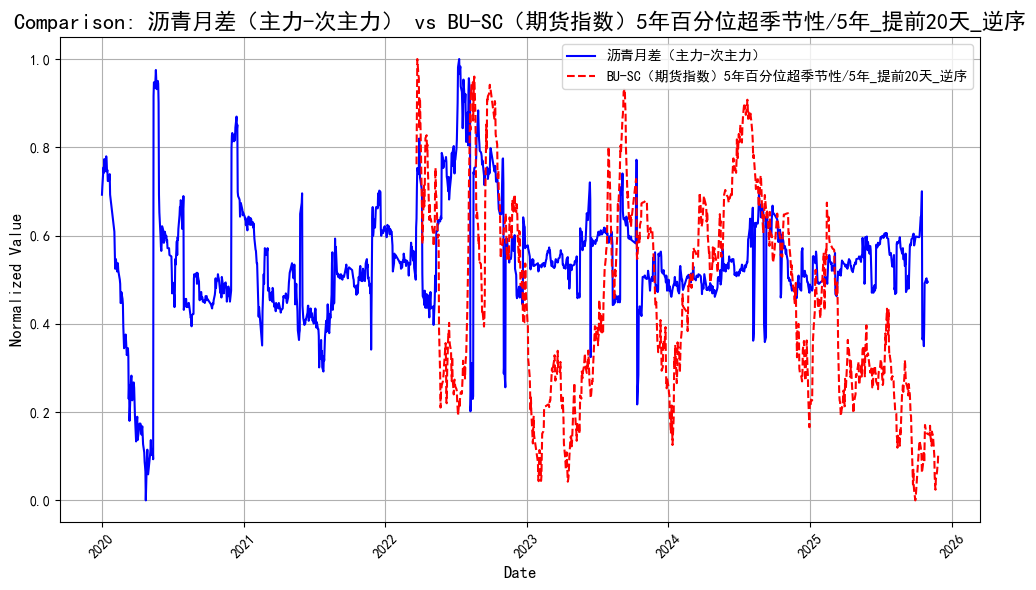

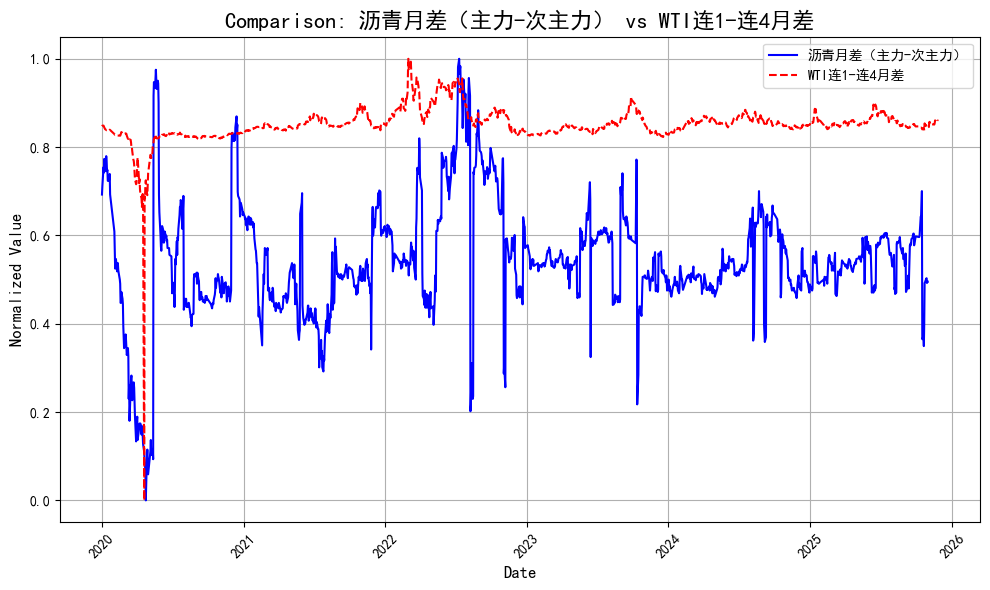

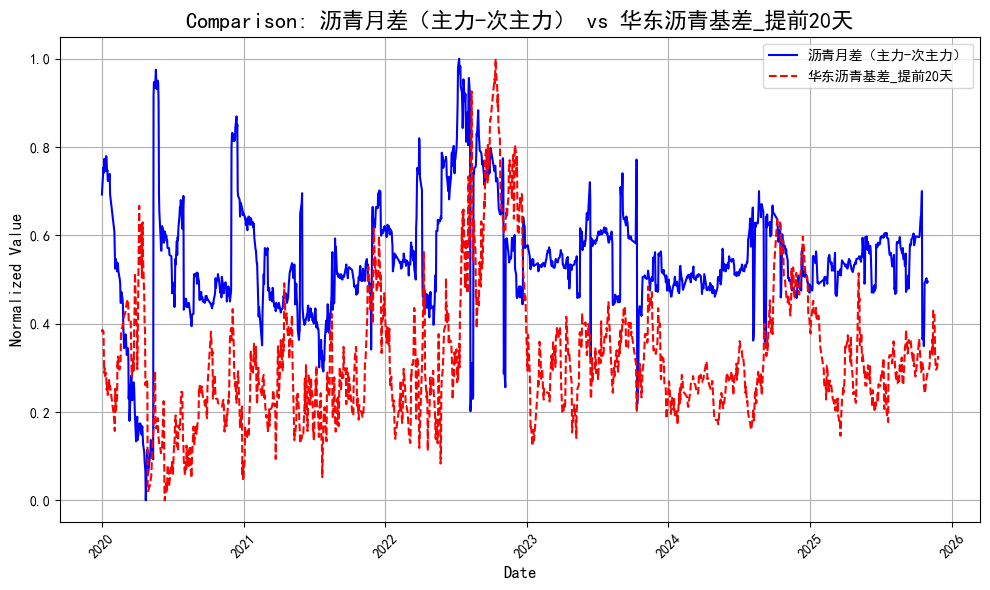

In [15]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='沥青月差（主力-次主力）', 
    compare_cols=[
        '山东汽柴油加权裂解价差_逆序',
       '沥青周度产量超季节性/3年_提前20天_逆序',
        '石油沥青：国内企业：库存：中国（周）同差_提前20天_逆序',
       '沥青仓单（仓库+厂库）同差_提前20天_逆序',
        '沥青厂库大样本拼接小样本4周环差_提前30天_逆序',
       'BU-SC（期货指数）5年百分位超季节性/5年_提前20天_逆序',
       'WTI连1-连4月差',
       '华东沥青基差_提前20天'
        ]
)

In [16]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '山东汽柴油加权裂解价差_逆序',
       '沥青周度产量超季节性/3年_提前20天_逆序',
        '石油沥青：国内企业：库存：中国（周）同差_提前20天_逆序',
       '沥青仓单（仓库+厂库）同差_提前20天_逆序',
        '沥青厂库大样本拼接小样本4周环差_提前30天_逆序',
       'BU-SC（期货指数）5年百分位超季节性/5年_提前20天_逆序',
       'WTI连1-连4月差',
       '华东沥青基差_提前20天'
]

predict_column = '沥青月差（主力-次主力）'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
# 原参数
params = {
     'objective': 'reg:squarederror',  # 回归任务
     'learning_rate': 0.01,  # 较小的学习率
     'max_depth': 13,  # 控制树的深度防止过拟合
     'min_child_weight': 2,  # 控制过拟合
     'subsample': 0.7,  # 随机采样防止过拟合
     'colsample_bytree': 0.7,  # 特征随机采样
     'gamma': 0.5,  # 控制分裂
     'reg_alpha': 0.5,  # L1正则化
     'reg_lambda': 0.5,  # L2正则化
     'eval_metric': 'rmse', # 评估指标：选择"rmse"
     'seed': 42, # 随机种子
     'tree_method': 'auto'
 }



num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:65.67904	train-rmse:75.37108


[500]	eval-rmse:55.17390	train-rmse:7.88806


[1000]	eval-rmse:54.97475	train-rmse:3.22656


[1500]	eval-rmse:54.92653	train-rmse:1.68993


[1999]	eval-rmse:54.93615	train-rmse:1.04787


训练集 MSE (DMatrix): 1.7693, 训练集 R² (DMatrix): 0.9998
测试集 MSE (DMatrix): 3017.9806, 测试集 R² (DMatrix): 0.2848


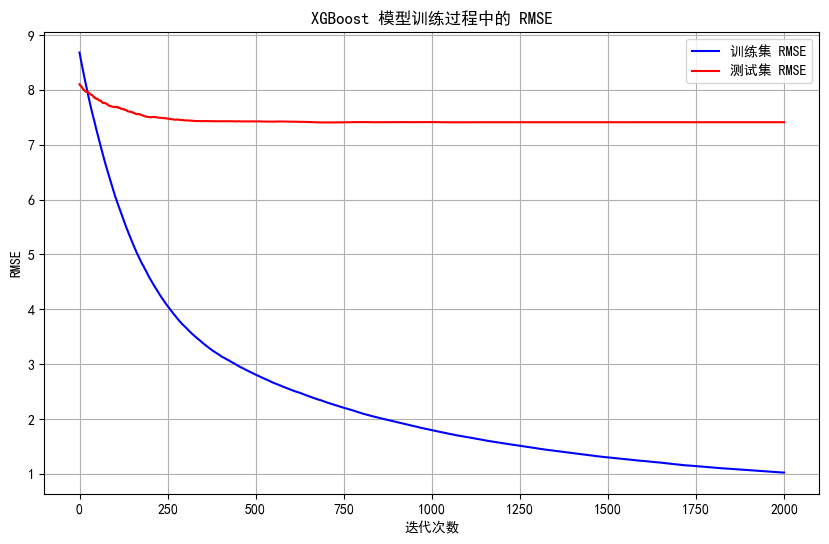

In [17]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:75.25330


[500]	train-rmse:7.68076


[1000]	train-rmse:2.99378


[1500]	train-rmse:1.38908


[1999]	train-rmse:0.77888


全部数据 MSE: 0.8189, 全部数据 R²: 0.9999


Gap between last actual value and first prediction: -0.7134113311767578


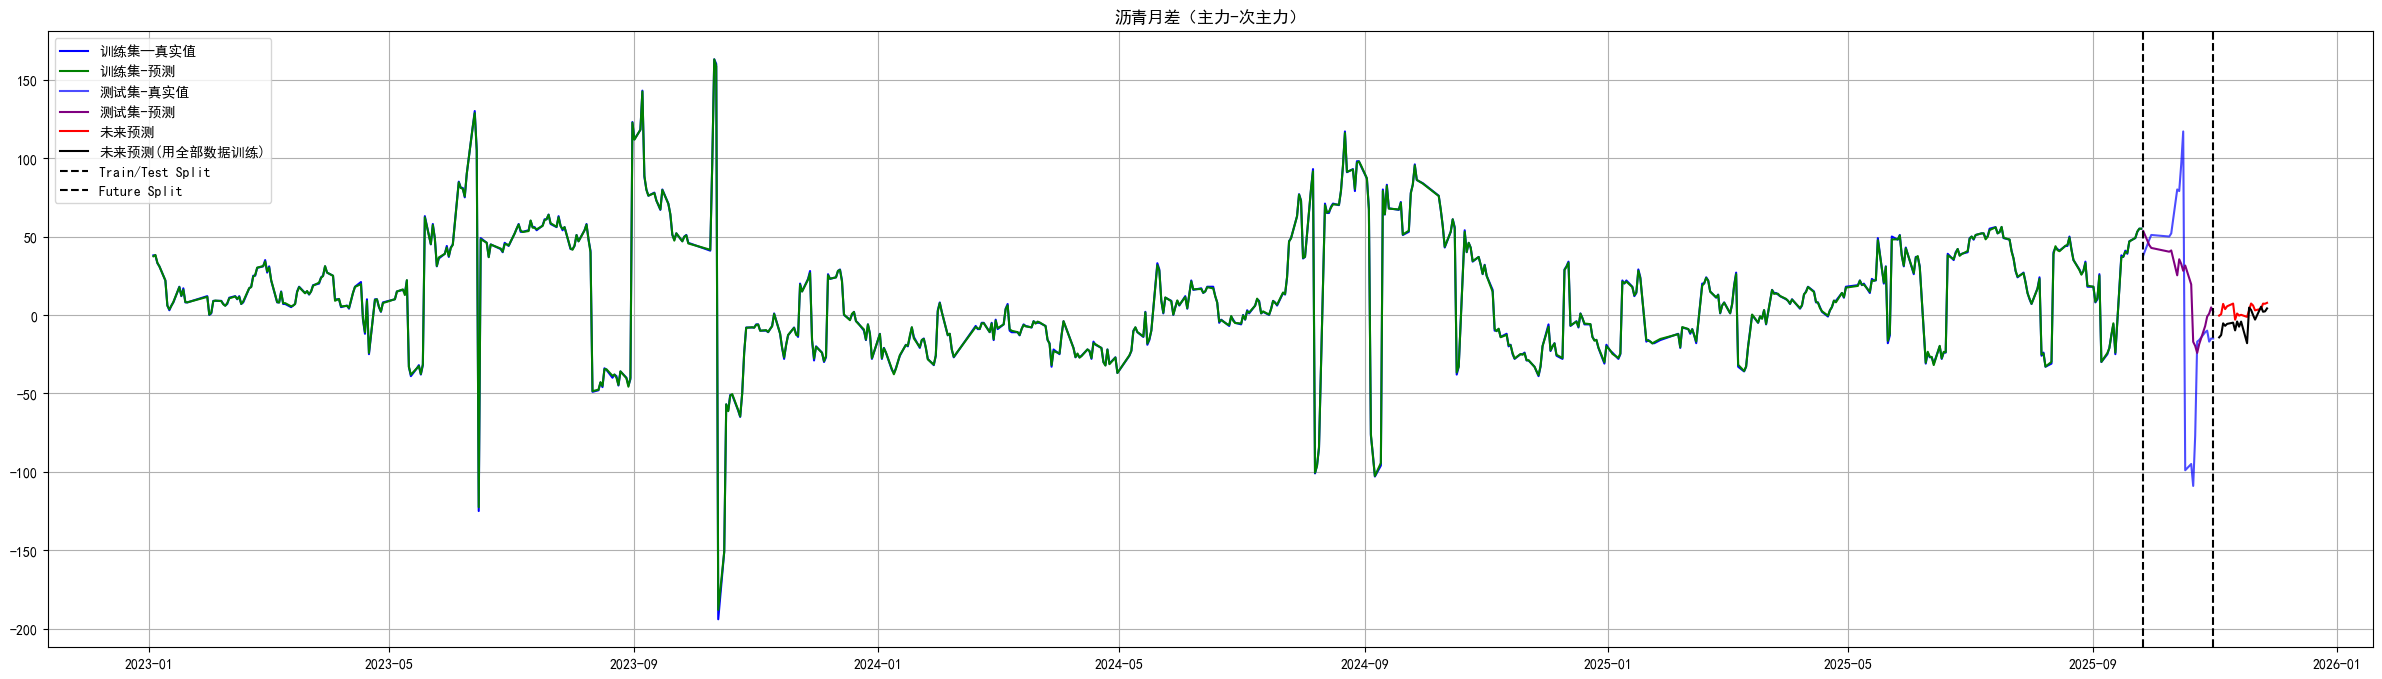

In [19]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)

# 过滤2023年之后的数据
mask_train = pd.to_datetime(train_data['Date']) >= '2023-01-01'
mask_test = pd.to_datetime(test_data['Date']) >= '2023-01-01'
mask_future = pd.to_datetime(future_data['Date']) >= '2023-01-01'

plt.plot(train_data.loc[mask_train, 'Date'], y_train[mask_train], label='训练集—真实值', color='blue')
plt.plot(train_data.loc[mask_train, 'Date'], y_train_pred_dmatrix[mask_train], label='训练集-预测', color='green')
plt.plot(test_data.loc[mask_test, 'Date'], y_test[mask_test], label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data.loc[mask_test, 'Date'], y_test_pred_dmatrix[mask_test], label='测试集-预测', color='purple')
plt.plot(future_data.loc[mask_future, 'Date'], future_data.loc[mask_future, '预测值'], label='未来预测', color='red')
plt.plot(future_data.loc[mask_future, 'Date'], future_data.loc[mask_future, '预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('沥青月差（主力-次主力）')  
plt.legend()
plt.grid(True)
plt.show()

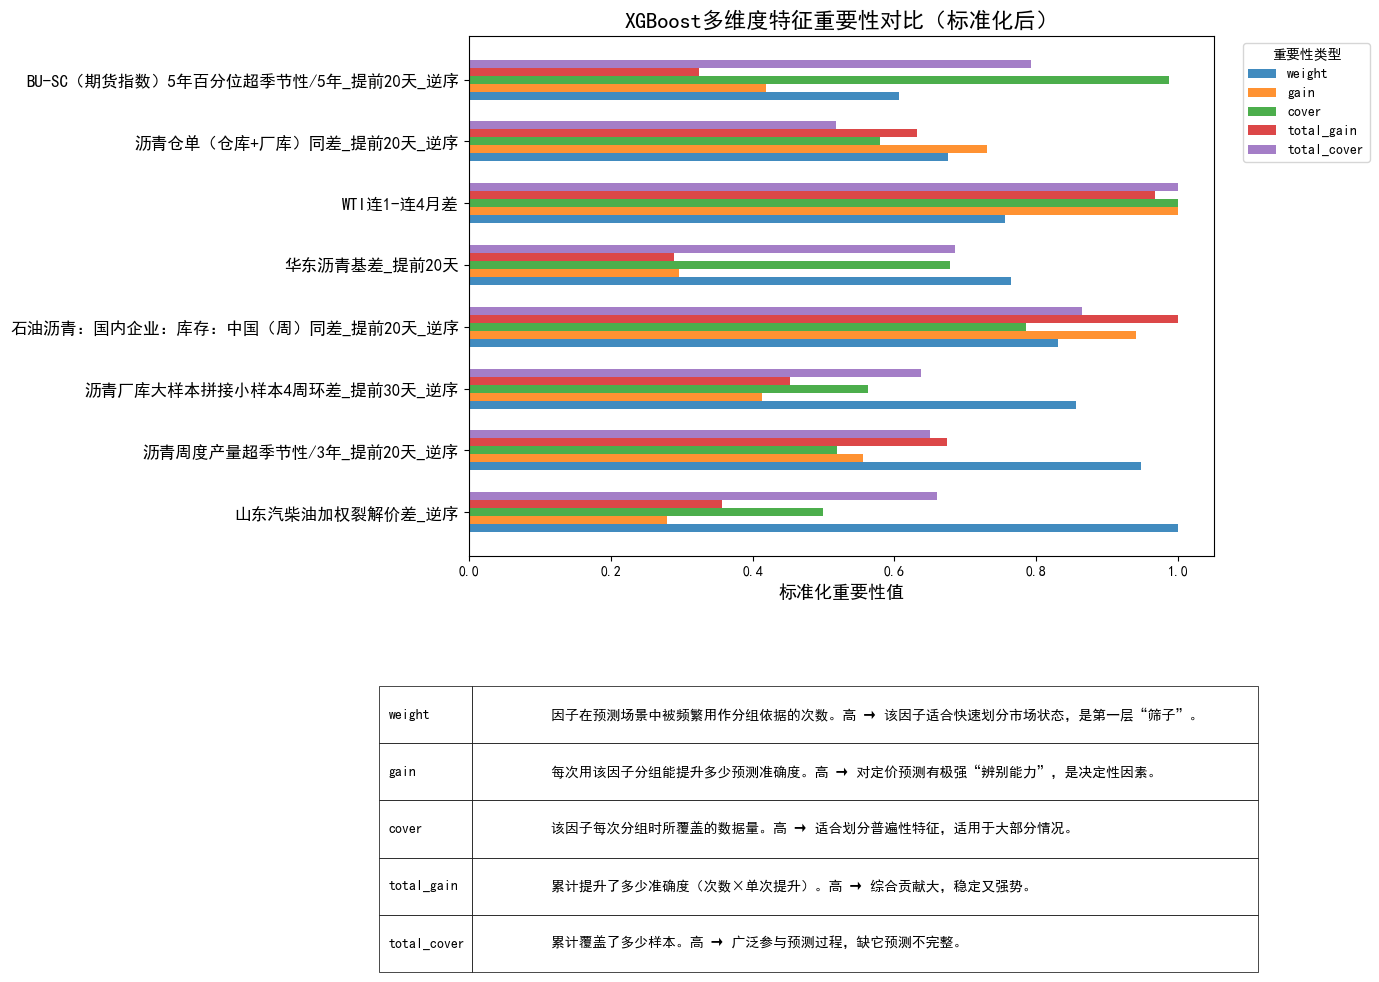

,weight,gain,cover,total_gain,total_cover
山东汽柴油加权裂解价差_逆序,1.000000,0.279125,0.498842,0.357209,0.659931
沥青周度产量超季节性/3年_提前20天_逆序,0.948210,0.555801,0.518651,0.674447,0.650603
沥青厂库大样本拼接小样本4周环差_提前30天_逆序,0.855270,0.413376,0.562872,0.452452,0.636866
石油沥青：国内企业：库存：中国（周）同差_提前20天_逆序,0.831161,0.940137,0.785894,1.000000,0.864142
华东沥青基差_提前20天,0.764115,0.296018,0.678522,0.289468,0.685896
WTI连1-连4月差,0.755900,1.000000,1.000000,0.967360,1.000000
沥青仓单（仓库+厂库）同差_提前20天_逆序,0.675230,0.730958,0.580078,0.631637,0.518172
BU-SC（期货指数）5年百分位超季节性/5年_提前20天_逆序,0.606067,0.418715,0.987650,0.324760,0.791880


In [20]:

#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)



---

In [21]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/沥青月差（主力-次主力）_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
702,2025/11/27,NaN,4.176662
701,2025/11/26,NaN,2.292554
700,2025/11/25,NaN,2.054562
699,2025/11/24,NaN,5.248873
698,2025/11/21,NaN,-2.962765
...,...,...,...
4,2023/01/09,22.0,NaN
3,2023/01/06,31.0,NaN
2,2023/01/05,33.0,NaN
1,2023/01/04,38.0,NaN


In [22]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.round(2)
# 保存成excel
merged_df_monthly.to_excel('eta/沥青月差（主力-次主力）_月度数据.xlsx', index=False, float_format='%.1f')

merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,-3.950000
33,2025/10/31,-0.41,10.240000
32,2025/09/30,22.41,22.660000
31,2025/08/31,21.43,21.320000
30,2025/07/31,42.22,42.139999
29,2025/06/30,8.40,8.480000
28,2025/05/31,25.84,25.760000
27,2025/04/30,8.95,8.930000
26,2025/03/31,-0.48,-0.470000
25,2025/02/28,2.11,2.150000


In [23]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.沥青_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "沥青月差（主力-次主力）"   

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [24]:
from Lcel import update_excel_data
file_path = "eta/1.沥青_数据上传.xlsx"
sheet_name = "详情页"
identifier = "沥青月差（主力-次主力）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
